# Lab 12: Gaussian Mixture Models (GMMs)

In lecture, we learned that the Gaussian Mixture Model (GMM) is a more sophisticated unsupervised clustering method than
$k$-means. The GMM models a dataset $(\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(m)})$ as an i.i.d. sample from the following
generative model for each sample
$\mathbf{x}^{(i)}$:

1. Sample $z^{(i)}$ from a multinomial distribution over clusters $1..k$ according to probabilities $(\phi_1,\ldots,\phi_k)$.
2. Sample $\mathbf{x}^{(i)}$ from ${\cal N}(\mathbf{\mu}_{z^{(i)}},\Sigma_{z^{(i)}})$.

The parameters are estimated using the Expectation Maximization (EM) algorithm, which begins with a guess for parameters
$\phi_1,\ldots,\phi_k,\mu_1,\ldots,\mu_k,\Sigma_1,\ldots,\Sigma_k$ then iteratively alternates between computing a soft assignment
of data to clusters then updating the parameters according to that soft assignment.

First, we'll build a GMM model for a dataset then use the model for anomaly detection.

## Example 1: Anomaly detection

Let's generate synthetic data from a mixture of Gaussians, use EM to recover as best possible the ground truth parameters, and
then use the model to find "anomalies" (unusually unlikely points according to the model). First, we set up the ground truth
parameters and generate a dataset from those ground truth parameters:

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Ground truth means and covariances for the data we'll generate

means_gt = [ [1,10], [10,1], [10,10] ]
sigmas_gt = [ np.matrix([[1, 0],[0, 1]]), np.matrix([[4,0],[0,1]]),
              np.matrix([[1,0],[0,4]]) ]

# Ground truth Prior probability (phi_j) for each cluster

phi_gt = [ 0.2, 0.2, 0.6 ]

# For more interesting covariances, you can also try, for example,
# [[11.31371, -0.70711],[11.31371, 0.70711]] or
# [[11.31371, 0.70711],[-11.31371, 0.70711]].

# Size of dataset

m = 500

# number of variables

n = len(means_gt[0])

# k number of clusters/outcomes

k = len(phi_gt)

# Ground truth indices of cluster identities

Z = [0]*m

# Generate a new k-means dataset

def gen_dataset():
    X = np.zeros((m,n))
    # Generate m samples from multinomial distribution using phi_gt
    z_vectors = np.random.multinomial(1, phi_gt, size=m)  # Result: binary matrix of size (m x k)
    for i in range(m):
        # Convert one-hot representation z_vectors[i,:] to an index
        Z[i] = np.where(z_vectors[i,:] == 1)[0][0]
        # Grab ground truth mean mu_{z^i}
        mu = means_gt[Z[i]]                
        # Grab ground truth covariance Sigma_{z^i}
        sigma = sigmas_gt[Z[i]]
        # Sample a 2D point from mu, sigma
        X[i,:] = np.random.multivariate_normal(mu,sigma,1)
    return X


X = gen_dataset()

Next, the EM algorithm itself. We have an initialization step and an iterative step.

In [57]:
def init_gmm(X, k):
    m = X.shape[0]
    n = X.shape[1]
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        # Initially assign equal probability to each cluster/outcome
        Phi[j] = 1/k      
        # Ramdomly assign mean to one of the data points       
        Mu[:,j] = X[order[j],:].T
        # Initial covariance is identity matrix
        Sigma[j,:,:] = np.eye(n)    
    return Phi, Mu, Sigma


def Gaussian(X, mean, covariance):
    k = len(mean)
    X = X - mean.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(covariance) * X, axis=1))
    return p


# Run one iteration of EM

def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    pj_arr = np.zeros((m,k))
    
    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        pj = Gaussian(X, Mu[:,j], Sigma[j,:,:])
        pj_arr[0:m,j] = pj
        W[:,j] = Phi[j] * pj

    # W tells us what is the relative weight of each cluster for each data point
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T

    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster specific W for each dimension
        Wj = np.tile(W[:,j],(2,1)).T
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])

    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False

    labels = np.argmax(pj_arr, axis = 1)
    pj = pj_arr[np.arange(0,m,1),labels]
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label


Let's run the model to convergence:

In [50]:
threshold = np.matrix(.01)

Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

[[ 1.19161235 -4.17701468 -1.2671492 ]
 [ 0.96714894 -0.87610215 -1.70442523]]
[[ 0.69710381 -1.04171931 -0.05659315]
 [-0.67253915 -0.02012343  0.10928068]]
[[ 0.20558804 -1.06921848 -0.01776336]
 [-0.27779562 -0.11715319  0.19989373]]
[[ 0.02471691 -1.04217722 -0.03022886]
 [-0.11551994 -0.18004201  0.13756952]]
[[-0.00242019 -0.9500851  -0.02402334]
 [-0.02536836 -0.18829843  0.09730006]]
[[-0.00108442 -0.86074976 -0.02036216]
 [-0.00589036 -0.17186578  0.06716425]]
[[-3.25892248e-04 -6.41868286e-01 -2.25226491e-02]
 [-1.19469010e-03 -1.10727272e-01  3.51246759e-02]]
[[-1.57976033e-04 -1.13751117e-01 -8.39936098e-03]
 [-1.53566059e-05 -9.87095853e-03  2.94505086e-03]]
[[ 7.01876084e-06 -8.93843837e-06 -4.19630866e-06]
 [ 4.18991635e-05  1.37737949e-06  5.15404266e-05]]


### In-class exercise

Determine how close the estimated parmeters Phi, Mu, and Sigma are to the ground trouth values set up at the beginning
of the experiment. Report your results and briefly discuss in your lab report.

Next, we continue to find outliers:

In [51]:
outlier_prob = .01
outliers = np.nonzero(pj < outlier_prob)[0]

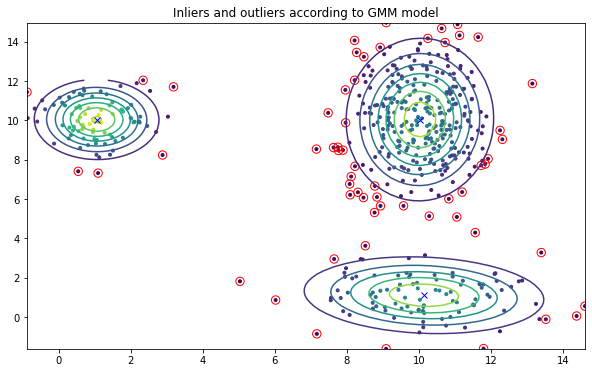

In [52]:
plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    xlist = np.linspace(min(X_class[:,0]), max(X_class[:,0]), 30)
    ylist = np.linspace(min(X_class[:,1]), max(X_class[:,1]), 30)
    
    XX, YY = np.meshgrid(xlist, ylist)
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX, YY, Z)
plt.title('Inliers and outliers according to GMM model')
plt.show()

### In-class exercise

Notice that using a hard threshold for each cluster gives us more outliers for a broad cluster than a
tight cluster. First, understand why, and explain in your report.  Second, read about Mahalanobis distance
of a point to the mean of a multivariate Gaussian distribution and see if you can use Mahalanobis distance
to get a better notion of outliers in this dataset.

## Example 2: Customer segmentation

In this example we will use the Kaggle customer segmentation
from last week dataset [Mall_Customers.csv](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python).

Let's stick to just two dimensions in the dataset:

In [41]:
data = pd.read_csv('Mall_Customers.csv')
data = data.drop(['CustomerID', 'Gender', 'Age'], axis = 1)
print(data.head())

   Annual Income (k$)  Spending Score (1-100)
0                  15                      39
1                  15                      81
2                  16                       6
3                  16                      77
4                  17                      40


In [58]:
X  = np.array(data, dtype=float)

n = X.shape[1]
m = X.shape[0]
k = 3

threshold = np.matrix(.01)

# Slightly different version of init_gmm due to the data format and spread
def init_gmm(X, k):
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        Phi[j] = 1/k
        Mu[:,j] = X[order[j],:].T
        Sigma[j,:,:] = np.cov(X.T)
    return Phi, Mu, Sigma


Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

### In-class exercise

Examine the cluster centers and determine whether you can find any reasonable interpretation of them.
Discuss in your report, and compare to last week's results with k-means.

Next, the visualization:

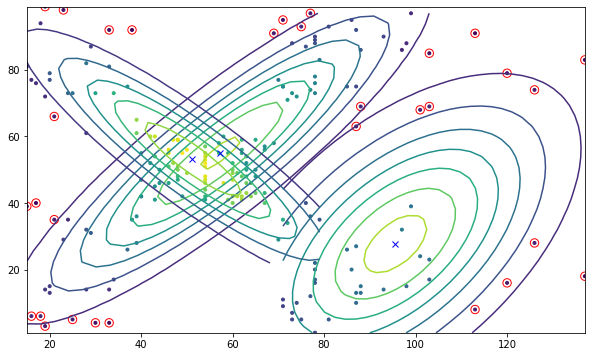

In [59]:
plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');

outlier_prob = .0001
outliers = np.nonzero(pj<outlier_prob)[0]
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    xlist = np.linspace(min(X_class[:,0]), max(X_class[:,0]), 30)
    ylist = np.linspace(min(X_class[:,1]), max(X_class[:,1]), 30)
    
    XX, YY = np.meshgrid(xlist, ylist)
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX, YY, Z)

plt.show()


### In-class exercise

Do the same analysis with Mahalanobis distance as in the first example.

### Example 3 Customer segmentation

This example is based on [Nguyen Hanh's tutorial on Medium.com](https://medium.com/@nguyenbaha/buiding-customer-segmentation-by-gmm-from-scratch-4ea6adc3da1c). In this example we use the Kaggle [OnlineRetail.csv](https://www.kaggle.com/vijayuv/onlineretail) dataset for customer segmentation. 

In [61]:
data = pd.read_csv('Online_Retail.csv')
data = data.iloc[0:5000,:]
print(data.head())
data = data.drop(['InvoiceNo','Description', 'CustomerID'], axis = 1)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice CustomerID         Country  TotalSum  
0   12/1/2010       2.55      17850  United Kingdom     15.30  
1   12/1/2010       3.39      17850  United Kingdom     20.34  
2   12/1/2010       2.75      17850  United Kingdom     22.00  
3   12/1/2010       3.39      17850  United Kingdom     20.34  
4   12/1/2010       3.39      17850  United Kingdom     20.34  


In [63]:
print(data.dtypes)

StockCode       object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
Country         object
TotalSum       float64
dtype: object


Let's view the categorical and numeric columns:

In [64]:
categorical_colmns = data.select_dtypes(include=['object']).columns
print(categorical_colmns)
numerical_colmns = data._get_numeric_data().columns
print(numerical_colmns)

Index(['StockCode', 'InvoiceDate', 'Country'], dtype='object')
Index(['Quantity', 'UnitPrice', 'TotalSum'], dtype='object')


In [65]:
def missing_percentage(data):
    """This function takes a DataFrame(df) as input and returns two columns, 
     total missing values and total missing values percentage"""
    total = data.isnull().sum().sort_values(ascending = False)
    percent = round(data.isnull().sum().sort_values(ascending = False)/len(data)*100,2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])


missing_percentage(data)



,Total,Percent
TotalSum,48,0.96
Country,12,0.24
UnitPrice,0,0.00
InvoiceDate,0,0.00
Quantity,0,0.00
StockCode,0,0.00


Next, let's fill the "na" values with "No information" and 0

In [66]:
data[categorical_colmns] = data[categorical_colmns].fillna("No information")
data[numerical_colmns] = data[numerical_colmns].fillna(0)

print(data.head())

  StockCode  Quantity InvoiceDate  UnitPrice         Country  TotalSum
0    85123A         6   12/1/2010       2.55  United Kingdom     15.30
1     71053         6   12/1/2010       3.39  United Kingdom     20.34
2    84406B         8   12/1/2010       2.75  United Kingdom     22.00
3    84029G         6   12/1/2010       3.39  United Kingdom     20.34
4    84029E         6   12/1/2010       3.39  United Kingdom     20.34


In [67]:
def category_to_numeric(categorical_columns):
    i = 0;
    columnname = '';
    while i < len(categorical_colmns):
        col_idx = data.columns.get_loc(categorical_colmns[i])
        distinct_values = data[categorical_colmns[i]].unique()
        j = 0;    
        for val in distinct_values:
            idx = np.where(data[categorical_colmns[i]] == val);
            data.iloc[idx[0],col_idx] = j            
            j = j + 1;
        i = i + 1;
        
        
category_to_numeric(data[categorical_colmns])

data = data.astype('float64')
print(data.head())

   StockCode  Quantity  InvoiceDate  UnitPrice  Country  TotalSum
0        0.0       6.0          0.0       2.55      0.0     15.30
1        1.0       6.0          0.0       3.39      0.0     20.34
2        2.0       8.0          0.0       2.75      0.0     22.00
3        3.0       6.0          0.0       3.39      0.0     20.34
4        4.0       6.0          0.0       3.39      0.0     20.34


In [68]:
Mu = np.std(data[numerical_colmns])
Sigma = np.mean(data[numerical_colmns])
print(Mu)
print(Sigma)

Quantity     146.544560
UnitPrice      5.908027
TotalSum      65.901813
dtype: float64
Quantity     10.941200
UnitPrice     3.252928
TotalSum     22.146162
dtype: float64


In [69]:
# Check for outliers

def cnt_outlier(data,sigma, mu, inc_cols=[]):
    num_cols = data.select_dtypes(include=[np.number]).columns
    num_cols = [e for e in num_cols if e in inc_cols]
    outlier = (data[numerical_colmns]-mu).abs() > sigma**2
    return outlier.sum()

cnt_outlier(data,Sigma,Mu, numerical_colmns).sort_values(ascending=False)

Quantity     4650
UnitPrice      56
TotalSum       12
dtype: int64

In [70]:
if len(data[data.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(data[data.duplicated()]))
    print(data[data.duplicated(keep=False)].sort_values(by=list(data.columns)).head())
    data.drop_duplicates(inplace=True)
else:
    print("No duplicated entries found")

No. of duplicated entries:  987
      StockCode  Quantity  InvoiceDate  UnitPrice  Country  TotalSum
4099        0.0       2.0          2.0       2.95      0.0       5.9
4131        0.0       2.0          2.0       2.95      0.0       5.9
4190        0.0       2.0          2.0       2.95      0.0       5.9
0           0.0       6.0          0.0       2.55      0.0      15.3
49          0.0       6.0          0.0       2.55      0.0      15.3


## In-class and take-home exercise

Use the same GMM code as in the previous two examples on this dataset. Try to interepret the
results you get and plot the inliers/outliers with a Mahalanobis distance
threshold. Plot likelihood as a function of $k$ and determine whether there is an "elbow"
in the plot. How many clusters should you use? Describe your experiments and results in your report.